In [1]:
# Standard preamble. 
import math as m 
import pandas as pd
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import PowerTransformer
import seaborn as sns
import numpy as np
import scipy
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt

# pytorch related stuf.. 
import torch
from torch.nn import Module 
import torch.nn as nn 
from torch.nn.functional import softmax 
from tqdm import tqdm 

/home/vigu/pyenvs/pytorch_latest/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def conditional_mean_imputation(X: np.array, pis: np.array, mus: np.array, Ss: np.array):
    mis_idx = pd.DataFrame(X).isna().to_numpy()
    for i in range(X.shape[0]):
        xis = X[i,:]
        mis = mis_idx[i,:]
        xi_d = xis[~mis]
        mu_d = mus[:,~mis]
        mu_m = mus[:,mis]
        Ss_dd = Ss[:, ~mis][:,:,~mis]
        Ss_md = Ss[:, mis][:,:,~mis]
        Ss_mm = Ss[:, mis][:,:,mis]
        dd_diff = np.expand_dims(xi_d - mu_d, -1)
        lmatrix_term = Ss_md @ (np.linalg.inv(Ss_dd))
        mu_tildes = mu_m + (lmatrix_term @ dd_diff)[:,:,0]

        zigs = density(xi_d, pis, mu_d, Ss_dd)
        zigs = zigs/zigs.sum()
        zigs[0,-1] = 1 - zigs[0,:-1].sum()
        zigs = zigs.transpose()
        xi_m_imputed = (mu_tildes * zigs).sum(0)
        xis[mis] = xi_m_imputed
    return X

In [4]:
def plot_imputed_values(df, ax1, ax2, ax3, colors) -> None:
    """
            Takes in a dataframe and spits out a figure named <fig_name>
            
            
    """
    # plt.rcParams['text.usetex'] = True

    marker_size = 1.7 
    alpha = 1.0

    #color_palatte = sns.color_palette("cubehelix",7)
    color_palatte = sns.color_palette("magma", 20)
    # colors = "blue" #df.labels.apply(lambda label: color_palatte[0])
    edge_color = "lightblue"# colors

    sns.scatterplot(x='Y_LL', y='Y_LI', data=df, ax=ax1, alpha=alpha, s=marker_size, edgecolor=edge_color, color=colors)
    sns.scatterplot(x='Y_PI', y='Y_LI', data=df, ax=ax2, s=marker_size, alpha=alpha, color=colors, edgecolor=edge_color)
    sns.scatterplot(x='Y_e', y='Y_LI', data=df, ax=ax3, s=marker_size, alpha=alpha, color=colors, edgecolor=edge_color)
    


def plot_li_vs_others(df, fig_name="li_vs_others.png") -> None:
    """
        Takes in a dataframe and spits out a figure named <fig_name>
        
        
    """
    # plt.rcParams['text.usetex'] = True


    fig, (ax1,ax2, ax3) = plt.subplots(1,3, figsize=(10,3))
    marker_size = 5.0
    alpha = 0.70

 #   color_palatte = sns.color_palette("bright",10)
#    marker_color_idx = 7
    marker_color = "grey"

    ax1.set_title('')
    sns.scatterplot(x='Y_LL', y='Y_LI', data=df, ax=ax1, alpha=alpha, s=marker_size, color=marker_color)
    ax1.set_xlabel(r"$Y_{LL}$")
    ax1.set_ylabel(r"$Y_{LI}$")

    ax2.set_title('')
    sns.scatterplot(x='Y_PI', y='Y_LI', data=df, ax=ax2, s=marker_size, alpha=alpha, color=marker_color)
    ax2.set_xlabel(r"$Y_{PI}$")
    ax2.set_ylabel("")
    ax2.axes.get_yaxis().set_visible(False)


    ax3.set_title('')
    sns.scatterplot(x='Y_e', y='Y_LI', data=df, ax=ax3, s=marker_size, alpha=alpha, color=marker_color)
    ax3.set_xlabel(r"$Y_{e}$")
    ax3.set_ylabel("")
    ax3.axes.get_yaxis().set_visible(False)
    fig.tight_layout()

    return ax1, ax2, ax3

In [5]:
df = pd.read_csv("SH_CLAY_11_4051.csv")

In [6]:
df.shape

(4052, 17)

In [7]:
df.describe()

,site ID,Depth\n(m),LL(%),PI,LI,e,K0,?'v (kPa),Su(UCST)\n(kPa),St(UCST),Su(VST)\n(kPa),St(VST),ps\n(MPa),?'v /Pa,Su(UCST)/?'v,Su(VST)/?'v,ps/?'v
count,4051.000000,4051.000000,2229.000000,4044.000000,2067.000000,3875.000000,264.000000,2658.000000,239.000000,181.000000,395.000000,384.000000,1249.000000,2658.000000,156.000000,379.000000,1245.000000
mean,29.939027,14.691629,40.305473,18.245920,1.149782,1.235333,0.508030,132.099737,26.799163,5.160773,40.601266,3.952604,0.741922,1.304045,0.209179,0.342663,6.286555
std,15.370566,6.032806,4.940774,3.220476,0.253424,0.177011,0.046968,46.447656,8.896784,1.478196,9.333694,0.656753,0.283412,0.458516,0.089144,0.130141,3.625273
min,0.000000,2.100000,26.300000,10.300000,0.490000,0.670000,0.430000,28.700000,12.000000,1.500000,20.500000,2.700000,0.300000,0.283317,0.104083,0.222841,2.551640
25%,17.000000,10.100000,35.800000,15.500000,0.930000,1.093000,0.470000,99.200000,21.000000,3.900000,34.150000,3.500000,0.570000,0.979269,0.152368,0.276287,4.688464
50%,31.000000,15.000000,41.200000,18.400000,1.170000,1.231000,0.500000,134.000000,25.000000,5.100000,39.200000,3.900000,0.700000,1.322804,0.189037,0.300527,5.269461
75%,43.000000,19.100000,44.200000,20.800000,1.330000,1.380000,0.530000,166.400000,31.000000,6.500000,47.000000,4.400000,0.850000,1.642646,0.232676,0.342532,6.168609
max,52.000000,30.000000,58.700000,30.900000,2.190000,1.863000,0.650000,274.400000,56.000000,7.600000,76.600000,7.800000,4.200000,2.708786,0.690691,1.135780,46.077210


In [8]:
df = df.iloc[1:,:]
df = df.iloc[:, 2:6]
df.columns = ["Y_LL","Y_PI","Y_LI","Y_e"]

In [9]:
df.sample(10)

,Y_LL,Y_PI,Y_LI,Y_e
980,NaN,17.4,NaN,1.120
2355,NaN,19.3,NaN,1.340
3561,43.8,21.5,0.92,1.194
91,37.6,16.2,0.98,1.048
3761,44.8,21.7,1.47,1.522
3121,NaN,18.2,NaN,1.340
4037,38.3,17.4,1.63,1.378
3330,45.1,21.7,1.28,1.417
480,NaN,14.9,NaN,1.170
638,NaN,14.0,NaN,1.000


In [10]:
na_mask = df.isna().any(axis=1)
df_na = df.loc[na_mask,:].copy()
na_mask = df.isna().all(axis=1)
df_na = df_na.loc[~na_mask,:]
na_mask = df.isna().any(axis=1)
df_clean = df.loc[~na_mask,:].copy()
df_clean

,Y_LL,Y_PI,Y_LI,Y_e
1,37.2,16.5,1.06,1.096
2,38.5,16.1,1.18,1.169
3,36.2,15.3,1.42,1.175
4,45.2,22.0,1.27,1.459
5,43.3,20.0,1.26,1.379
...,...,...,...,...
4047,33.9,14.4,1.51,1.166
4048,40.4,18.5,1.06,1.180
4049,32.2,13.8,1.34,1.035
4050,36.3,16.1,1.17,1.097


### Histogram before transformation

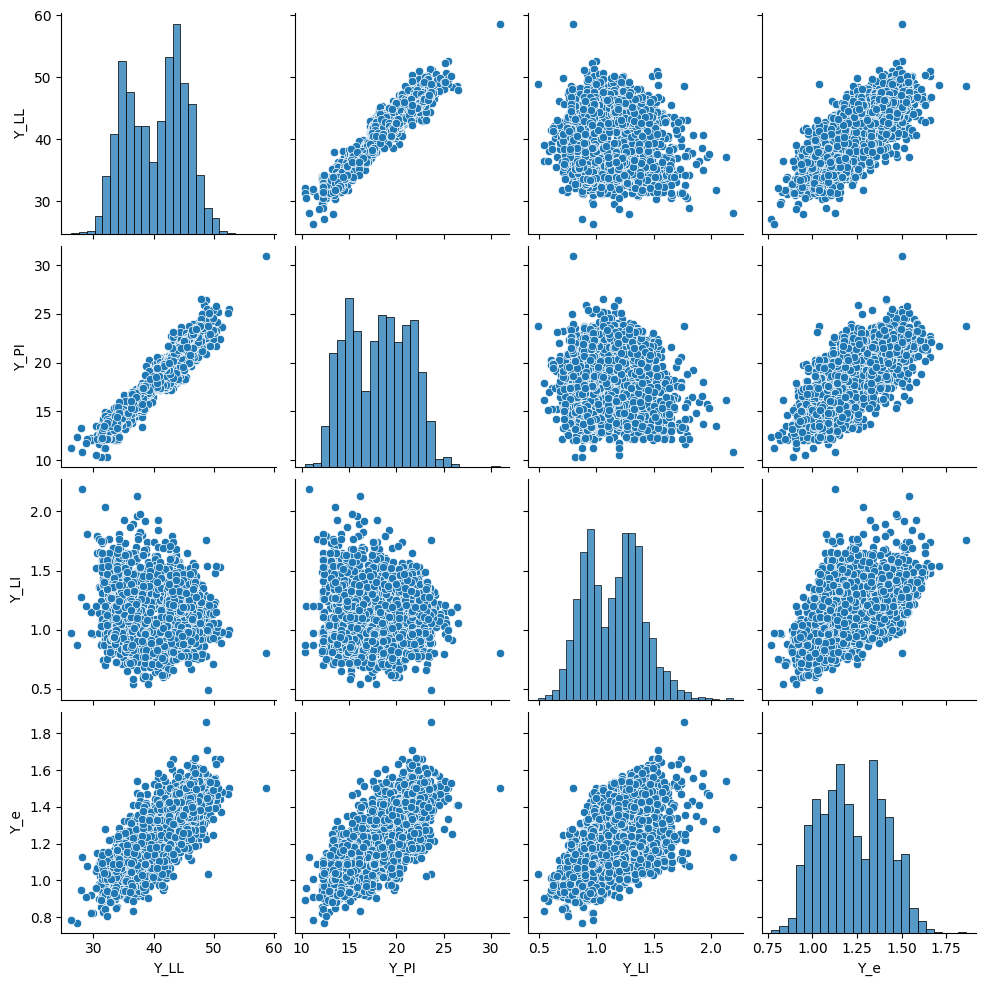

In [11]:
sns.pairplot(df_clean)

In [12]:
# Mixture model
Gs = range(2,12)
best_bic = float("inf")
best_G = None
best_model = None
for G in Gs:
    mm = GaussianMixture(n_components=G)
    # fit 
    mm.fit(df_clean.to_numpy())
    bic = mm.bic(df_clean.to_numpy())
    print(f"G: {G}, BIC: {bic}")
    if bic < best_bic:
        best_bic = bic
        best_G = G
        best_model = mm

G: 2, BIC: 8035.869113024208
G: 3, BIC: 7758.841079623747
G: 4, BIC: 7694.920130483311
G: 5, BIC: 7566.92106739072
G: 6, BIC: 7179.38356446692
G: 7, BIC: 7152.690241815551
G: 8, BIC: 7222.910430403342
G: 9, BIC: 7332.96335720706
G: 10, BIC: 7291.4271862521355
G: 11, BIC: 7596.776039519927


In [13]:
print(f"Best G: {best_G}, Best BIC: {best_bic}")
mus = best_model.means_
ss = best_model.covariances_
pis = best_model.weights_

Best G: 7, Best BIC: 7152.690241815551
(7, 4)
(7, 4, 4)
(7,)


In [14]:
x_imputed_array = conditional_mean_imputation(df_na.copy().to_numpy(), pis, mus, ss)
df_imputed = pd.DataFrame(x_imputed_array)
df_imputed.columns = df_na.columns

### Imputed data without using transformation, grey are fully complete points, blue are imputed points

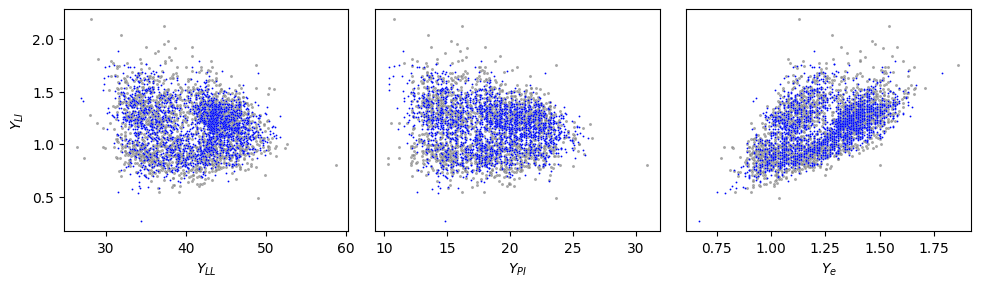

In [15]:
ax1, ax2, ax3 = plot_li_vs_others(df_clean)
plot_imputed_values(df_imputed, ax1, ax2, ax3, colors="blue")
plt.show()

In [16]:
# Let's use Box-Cox
transformer = PowerTransformer(method="box-cox")
df_transform = transformer.fit_transform(df)
df_transform = pd.DataFrame(df_transform)
df_transform.columns = df.columns

In [18]:
na_mask = df_transform.isna().any(axis=1)
df_transform_na = df_transform.loc[na_mask, :].copy()
na_mask = df_transform.isna().all(axis=1)
df_transform_na = df_transform_na.loc[~na_mask, :]
na_mask = df_transform.isna().any(axis=1)
df_transform_clean = df_transform.loc[~na_mask, :].copy()

### Histogram after power transformation

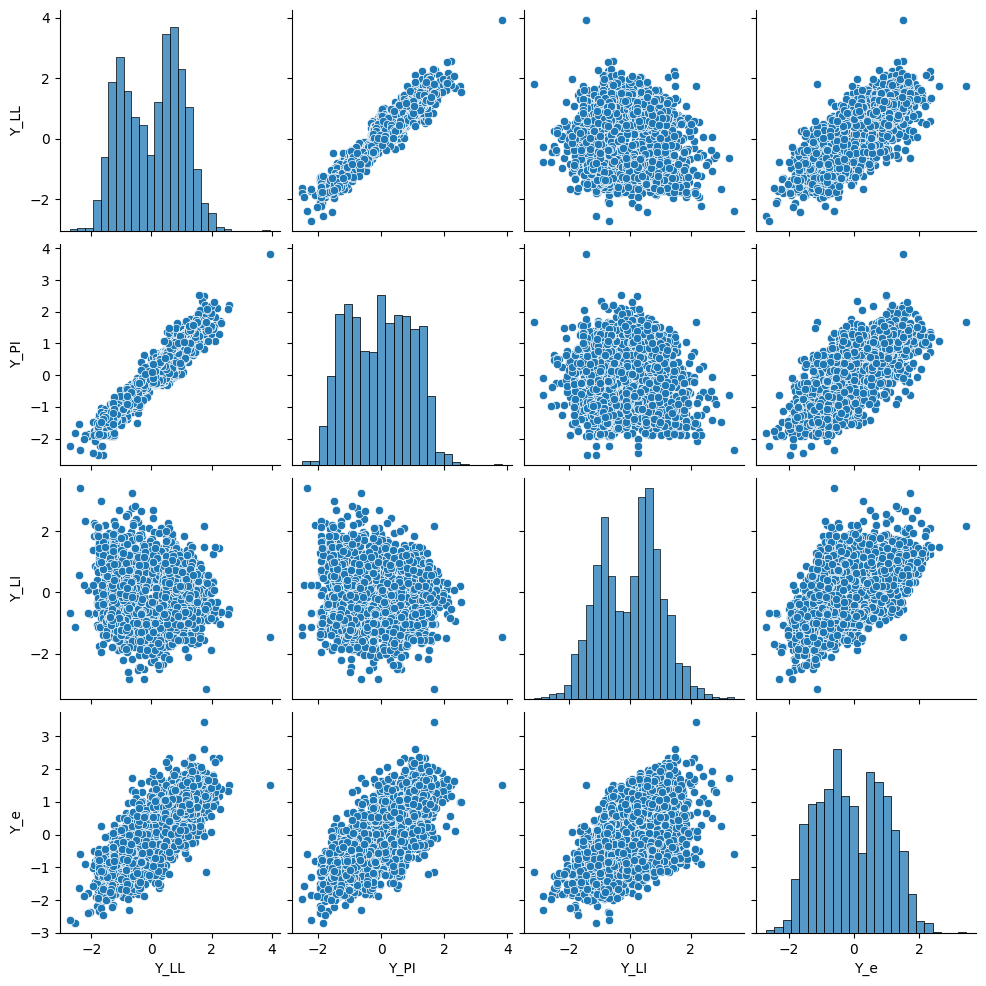

In [19]:
sns.pairplot(df_transform_clean)

In [20]:
# Mixture model
Gs = range(2,12)
best_bic = float("inf")
best_G = None
best_model = None
for G in Gs:
    mm = GaussianMixture(n_components=G)
    # fit 
    mm.fit(df_transform_clean.to_numpy())
    bic = mm.bic(df_transform_clean.to_numpy())
    print(f"G: {G}, BIC: {bic}")
    if bic < best_bic:
        best_bic = bic
        best_G = G
        best_model = mm

G: 2, BIC: 9459.914484091116
G: 3, BIC: 9065.390618065321
G: 4, BIC: 8889.341851582007
G: 5, BIC: 8468.910962476375
G: 6, BIC: 8493.486894077529
G: 7, BIC: 8487.271827314918
G: 8, BIC: 8487.046548190037
G: 9, BIC: 8540.790894972135
G: 10, BIC: 8352.068208111259
G: 11, BIC: 8261.115513017185


In [21]:
print(f"Best G: {best_G}, Best BIC: {best_bic}")
mus = best_model.means_
ss = best_model.covariances_
pis = best_model.weights_
print(mus.shape)
print(ss.shape)
print(pis.shape)

Best G: 11, Best BIC: 8261.115513017185
(11, 4)
(11, 4, 4)
(11,)


In [22]:
x_imputed_array = conditional_mean_imputation(df_transform_na.copy().to_numpy(), pis, mus, ss)
df_imputed = pd.DataFrame(x_imputed_array)
df_imputed.columns = df_transform_na.columns

In [23]:
df_inverse_transform_clean = transformer.inverse_transform(df_transform_clean)
df_inverse_transform_clean = pd.DataFrame(df_inverse_transform_clean)
df_inverse_transform_clean.columns = df_transform_clean.columns
df_inverse_transform_na = transformer.inverse_transform(df_imputed)
df_inverse_transform_na = pd.DataFrame(df_inverse_transform_na)
df_inverse_transform_na.columns = df_imputed.columns

### Imputed data using transformation separately , grey are fully complete points, red are imputed points

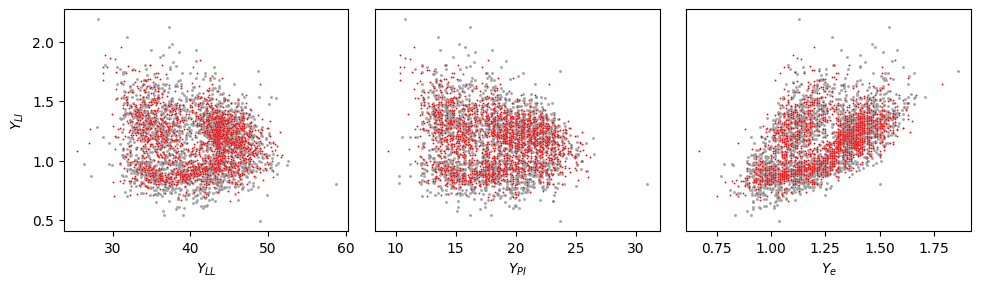

In [24]:
ax1, ax2, ax3 = plot_li_vs_others(df_inverse_transform_clean)
plot_imputed_values(df_inverse_transform_na, ax1, ax2, ax3, colors="red")
plt.show()

### Custom implementation of Gaussian mixture model

In [181]:
class GaussianMixtureModel(nn.Module):
    """
        Class for Finite mixtures of Gaussian models. 
    """
   
    def __init__(self, G:int, data: torch.Tensor):
        """
            Constructor class for finite mixtures of linear models.  
        """
        
        if not isinstance(data, torch.Tensor):
            raise Exception("data is not of torch.Tensor type") 

        super(GaussianMixtureModel, self).__init__() 

        # define data 
        self.X = data

        # define constants. 
        self.n = data.shape[0] 
        self.G = G if G > 0 else exec("raise Exception('G has to be valid')") 
        self.p = self.X.shape[1]         

        # Parameter for transformation, small value of lambda may cause
        # loss to go nan initially, so multiply it with a constant
        self.lambdas = torch.rand(self.p, 1)

        # define actual parameters based on random chunking
        self.mus = torch.zeros(G, self.p)
        self.sigmas = torch.zeros(G, self.p, self.p)
        for i, xs in enumerate(torch.chunk(self.transform(self.X), self.G)):
            self.mus[i,:] = xs.mean(axis=0)
            self.sigmas[i,:,:] = torch.cov(xs.T)
        # define weights
        self.w = torch.rand(G,1)

        # latent variable matrix of dimension = n * G
        self.z = np.random.normal(size=(self.n, self.G))
        # Z_ij should sum up to one for all i's and a given j
        self.z = scipy.special.softmax(self.z, axis=1)
        self.z = torch.Tensor(self.z)

        # set gradients. 
        self.w.requires_grad = True
        self.mus.requires_grad = True
        self.sigmas.requires_grad = True
        self.lambdas.requires_grad = True

        self.lbfgs_optimizer = torch.optim.LBFGS([self.lambdas], max_iter=1, lr=0.01)

        self.leading_constant = - (self.p / 2) * torch.Tensor([2.0 * torch.pi]).log()
    
    def lbfgs_closure(self):
        self.lbfgs_optimizer.zero_grad()
        cost = self.objective_fn()
        cost.backward() # compute gradient. 
        return cost

    def compute_weights(self):
        """
            get mixing proportions. 
        """
        return softmax(self.w[:,0], dim=0)

    def transform(self, X):
        # Box-cox transform
        X_transform = torch.clone(X)
        for p in range(self.p):
            X_transform[:, p] = (X[:, p] ** self.lambdas[p] - 1) / self.lambdas[p]
        return X_transform
    
    def inverse_transform(self, X):
        # Inverse of box-cox transform
        X_inv_transform = torch.clone(X)
        for p in range(self.p):
            X_inv_transform[:, p] = ((X[:, p] * self.lambdas[p]) + 1) ** (1 / self.lambdas[p])
        return X_inv_transform

    def log_density(self):
        # Log of multivariate normal density
        # f(x) = (1/2pi)^(p/2) * |Sigma|^(-1/2) * exp(-1/2 * (x - mu).T @ Sigma^(-1) @ (x - mu)) * |Jacobian|
        # log(f(x))

        X_transform = self.transform(self.X)
        n = X_transform.shape[0]
        ldens = torch.zeros(n, self.G) 
        for j in range(G):
            Ss_inv = torch.linalg.inv(self.sigmas[j,:,:])
            leading_constant_1 = - 0.5 * torch.linalg.det(self.sigmas[j,:,:]).log()
            for i in range(n):
                xm = (X_transform[i,:] - self.mus[j,:]).unsqueeze(1)
                res = -0.5 * (xm.T @ Ss_inv @ xm)[0][0]
                res += self.leading_constant.squeeze() + leading_constant_1
                # Add log jacobian for box-cox transform
                res += (self.X[i, :].log().unsqueeze(0) @ (self.lambdas - 1))[0][0]
                ldens[i][j] = res
        return ldens

    def objective_fn(self):
        """
            Objective function to minimize on, 
            takes in an (n x d + 1) matrix with the response variable 
            in the first column 
        """
        
        # compute log densities. 
        dens = self.log_density().exp() 

        # get weights. 
        W = self.compute_weights() 
        
        return -((dens * W).sum(-1).log()).sum() 
        
    def train(self, lr=1e-3, max_iterations=1000): 
        """
            train using some gradient descent algorithm 
        """

        # define optimizer 
        optimizer = torch.optim.Adam([self.w,
                                      self.mus, 
                                      self.sigmas], lr=lr)
        # track loss 
        loss = np.zeros(max_iterations)
        tq_obj = tqdm(range(max_iterations), desc="Model Training")
       
        for it in tq_obj:
            optimizer.zero_grad() 
            cost = self.objective_fn(self.X)
            cost.backward() # compute gradient. 
            optimizer.step() 

            loss[it] = cost.data.cpu().numpy() 
            
            # log the loss. 
            if it % 100 == 0:    
                tqdm.write(f"Loss: {loss[it]}  λ: {optimizer.param_groups[0].get('lr')}")

    def BIC(self):
        """
            Calculates the Bayesian Information Criterion for model performance comparisons.
        """

        # calculate number of parameters. 
        rho = self.mus.numel() + self.sigmas.numel() + self.w.numel()
        bic = self.objective_fn() * (-2.0) - rho * m.log(self.X.shape[0])
        return float(bic.detach())

    def Estep(self):
        """
            Computes the expectation step using parameters for X ,y
        """
        
        with torch.no_grad():
            dens = self.log_density().exp()

            W = self.compute_weights() 
            dens = dens * W
            
            d_sum = dens.sum(-1).unsqueeze(-1)
            dens = dens / d_sum 

        self.z = dens

    def Mstep(self):
        """
        Estimate parameters to maximize likelihood
        """
        X_transform = self.transform(self.X)
        with torch.no_grad():
            self.w = (self.z.sum(axis=0)/self.z.shape[0]).unsqueeze(-1)
            for g in range(self.G):
                self.mus[g,:] = (self.z[:,g].unsqueeze(-1) * X_transform).sum(0) / self.z[:,g].sum()
            for g in range(self.G):
                xm = X_transform - self.mus[g,:]
                self.sigmas[g,:,:] = ((xm.T * self.z[:,g]) @ xm) / self.z[:,g].sum()
        # Estimate lambdas using LBFGS
        # self.lbfgs_optimizer.step(self.lbfgs_closure) 

    def train_EM(self, max_iter=10):
        """Run EM algorithm"""
        for it in tqdm(range(max_iter), desc="Running EM algo"):
            self.Estep()
            self.Mstep()

        print(f"Loss: {self.objective_fn()}")

### Run custom Gaussian mixed model on untransformed dataset, it learns transformation parameters jointly with GMM parameters

In [172]:
na_mask = df.isna().any(axis=1)
df_na = df.loc[na_mask,:].copy()
na_mask = df.isna().all(axis=1)
df_na = df_na.loc[~na_mask,:]
na_mask = df.isna().any(axis=1)
df_clean = df.loc[~na_mask,:].copy()

In [182]:
# Mixture model
X = df_clean.copy().to_numpy()
X = torch.Tensor(X)
Gs = range(8,11)
best_bic = float("inf")
best_G = None
best_model = None
for G in Gs:
    mm = GaussianMixtureModel(G=G, data=X)
    # fit 
    mm.train_EM(max_iter=50)
    bic = -mm.BIC()
    print(f"G: {G}, BIC: {bic}")
    if bic < best_bic:
        best_bic = bic
        best_G = G
        best_model = mm
print(f"Best G: {best_G}, Best BIC: {best_bic}")

Running EM algo: 100%|██████████| 50/50 [01:00<00:00,  1.21s/it]


Loss: 2992.87060546875
G: 8, BIC: 7268.1474609375


Running EM algo: 100%|██████████| 50/50 [01:07<00:00,  1.35s/it]


Loss: 3001.159912109375
G: 9, BIC: 7445.02685546875


Running EM algo: 100%|██████████| 50/50 [01:19<00:00,  1.58s/it]


Loss: 2934.6201171875
G: 10, BIC: 7472.248046875
Best G: 8, Best BIC: 7268.1474609375


In [183]:
mus = best_model.mus.detach().numpy()
sigmas = best_model.sigmas.detach().numpy()
w = best_model.w.numpy().squeeze()

In [184]:
x_array_na = best_model.transform(torch.Tensor(df_na.to_numpy())).detach().numpy()
x_imputed_array = conditional_mean_imputation(x_array_na, w, mus, sigmas)
x_imputed_array_inv_transform = best_model.inverse_transform(torch.Tensor(x_imputed_array)).detach().numpy()

In [185]:
df_imputed = pd.DataFrame(x_imputed_array_inv_transform)
df_imputed.columns = df_transform_na.columns

### Imputed data using transformation **jointly**, grey are fully complete points, brown are imputed points

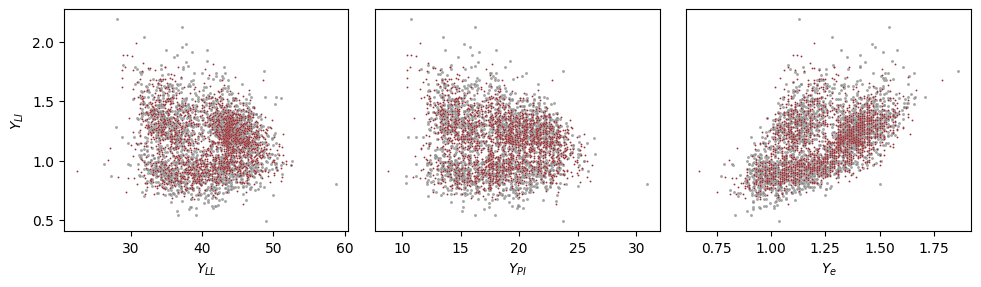

In [186]:
ax1, ax2, ax3 = plot_li_vs_others(df_clean)
plot_imputed_values(df_imputed, ax1, ax2, ax3, colors="brown")
plt.show()